### Assignment 3 Version 2 

##### Deliar Mohammadi, 30072994
##### John Zheng,30125258
##### Xinzhou Li, 30066080



In [86]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch_optimizer as optim
from torchsummary import summary
from torchvision.models import resnet50, ResNet50_Weights, ResNet101_Weights, ResNet152_Weights

import PIL
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import random
import os
import glob
from tqdm import tqdm

### Building Train and Test Data classes

In [87]:
df_csv = pd.DataFrame(pd.read_csv("./Assignment 3 Dataset/train.csv"))
train_paths = df_csv["id"].to_list()
train_labels = df_csv["label"].to_list()

In [88]:
class Data():
    def __init__(self, root, paths, labels, transform=None, ext='.jpg'): # move transform into training loop
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.root = root
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label
     
    '''
    get the img,label tuple corresponding to index i
    '''
    def get_no_transform(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        label = self.labels[i] if self.labels else None
        return img, label
    
    '''
    Selects random start point in the dataset and prints 28 images
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self.get_no_transform(i)
            axis.imshow(x[0])
            label = x[1]
            axis.set_xlabel(label)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = (self.get_no_transform(i))[0]
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self)
        avgh = totalh//len(self)
        return avgw, avgh

## Preparing Training & Validation datasets, dataloaders and transforms

In [89]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.05)),
    transforms.ColorJitter(brightness=0.2),
    # transforms.ColorJitter(contrast=0.2),
    # transforms.ColorJitter(saturation=0.2),
    
    transforms.Resize(size=256),     
    torchvision.transforms.CenterCrop(224), #required for resnet50 input: 224x224
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalized with imagenet mean and std deviation
])

In [90]:
test_transform = transforms.Compose([
    transforms.Resize(size=256),     
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [91]:
train_dataset = Data("./Assignment 3 Dataset", train_paths, train_labels, train_transform)

In [92]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### Sampels of training and test data

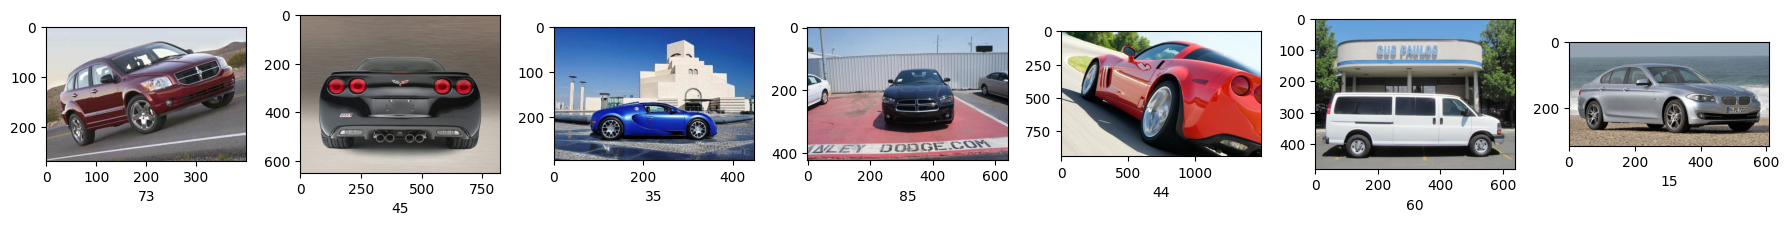

In [93]:
train_dataset.print_samples()

## Building the Model and Training

In [94]:
class A3ResNetV2():
    def __init__(self, device):
        self.device = device
        
        self.model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2).to(self.device)
        
        self.fc = nn.Sequential(
            nn.Linear(2048, 1600),
            nn.Tanh(),
            nn.Linear(1600, 1200),
            nn.Tanh(),
            nn.Linear(1200, 800),
            nn.Tanh(),
            nn.Linear(800, 600),
            nn.Tanh(),
            nn.Linear(600, 400),
            nn.Tanh(),
            nn.Linear(400, 200),
            nn.Tanh(),
            nn.Linear(200, 100)
        )
        
        self.model.fc = self.fc
        self.model.to(self.device)
    
    '''
    freeze all feature layers in the network, does not freeze the fully
    connected layer at the end
    '''
    def freeze_features(self):
        for name,param in self.model.named_parameters():
            if "fc" in name:
                continue
            else:
                param.requires_grad=False
    
    '''
    unfreeze all features, gradient calculates for all conv layers with this called
    '''
    def unfreeze_features(self):
        for param in self.model.parameters():
            param.requires_grad = True
    
    '''
    helper function to check which layers have gradient calculating.
    Yes means its being updated, and No is not updated
    '''
    def print_grad_settings(self):
        for i in self.model.parameters():
            if i.requires_grad==True:
                print("YES")
            else:
                print("NO")
    
    '''
    helper function to print model and summary
    '''
    def print_model(self):
        summary(self.model, (3,224,224))
    
    '''
    function to train the model on a given dataloader,optimizer, and loss function.
    runs for specified number of epochs.
    '''
    def train_model(self, epochs, train_dataloader, optimizer, loss_function):
        self.model.train()
        for i in tqdm(range(epochs)):
            
            epoch_loss = 0
            num_examples = 0
            correct_examples = 0
            
            for batch_index,(images,labels) in enumerate(train_dataloader):
                # reset optimizer for the current batch
                optimizer.zero_grad() 
                # load images and labels
                images = images.to(device)
                labels = labels.to(device)
                # calculate output and loss from output
                outputs = self.model(images)
                loss = loss_function(outputs,labels)
                # loss.backward() calculates all gradients for all params, optimizer.step() updates params using our optimizer
                loss.backward()
                optimizer.step()
                # calculate information for this epoch
                epoch_loss += loss.item()*len(labels)
                num_examples += len(labels)
                # calculate predictions and accuracy
                _,preds = torch.max(outputs,1) # calcualtae max in each column (second value=1 for column)
                # print("Preds",preds)
                correct_examples += (preds==labels).sum().item()
                
            # AFTER epoch we calculate accuracy
            train_accuracy = (correct_examples/num_examples)*100
            print(f'Epoch {i}: Training Accuracy: {train_accuracy:.4f}%, Training Loss: {epoch_loss:.4f}')

    '''
    validates model on validation set
    '''
    def validate_model(self, validation_dataloader):
        self.model.eval() 
        num_examples = 0
        correct_examples = 0
        
        for batch_index,(images,labels) in tqdm(enumerate(validation_dataloader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            num_examples += len(labels)
            _ , preds = torch.max(outputs,1)
            # print(preds)
            correct_examples += (preds==labels).sum().item()
            
        validation_accuracy = (correct_examples / num_examples)*100
        print(f'Validation Accuracy: {validation_accuracy:.20f}%')


### Building and training the model

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [97]:
resnet = A3ResNetV2(device)

In [98]:
resnet.freeze_features()

In [99]:
resnet.unfreeze_features()

In [ ]:
resnet.print_grad_settings()

In [101]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.model.parameters(), lr=0.001)

In [ ]:
resnet.train_model(5, train_dataloader, optimizer, loss_function)
# torch.save(resnet.model, "model.h")

### Testing the Model

In [103]:
class TestData():
    def __init__(self, root, paths,transform=None, ext='.jpg'): # move transform into training loop
        self.paths = paths
        self.transform = transform
        self.root = root
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img in index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        img = self.transform(img)
        return img
    
    '''
    predict output for each test image
    '''
    def predict(self, dataloader, model):
        all_preds = torch.Tensor([]).to(device) # specify dtype
        model.eval()
        for batch_index,images in enumerate(dataloader):
            test_images = images.to(device)
            outputs = model(test_images)
            _,preds = torch.max(outputs,1) # calcualtae max in each column (second value=1 for column)
            all_preds = torch.cat((all_preds,preds))
        preds = all_preds.tolist()
        preds = [int(x) for x in all_preds]
        return preds
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def get_no_transform(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        return img
    
    '''
    print sample data from test
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self.get_no_transform(i)
            axis.imshow(x)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    write predictions into answer.csv for submission to kaggle
    '''
    def write_predictions(self, predictions, csv_file, output_file):
        file = pd.read_csv(self.root+"/"+csv_file)
        file['Predicted'] = predictions
        file.to_csv(output_file, sep=',', index=False)


### Building test set and writing predictions

In [104]:
test_csv = pd.DataFrame(pd.read_csv("./Assignment 3 Dataset/test.csv"))
test_paths = test_csv["id"].values

In [105]:
test_dataset = TestData("./Assignment 3 Dataset", test_paths, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

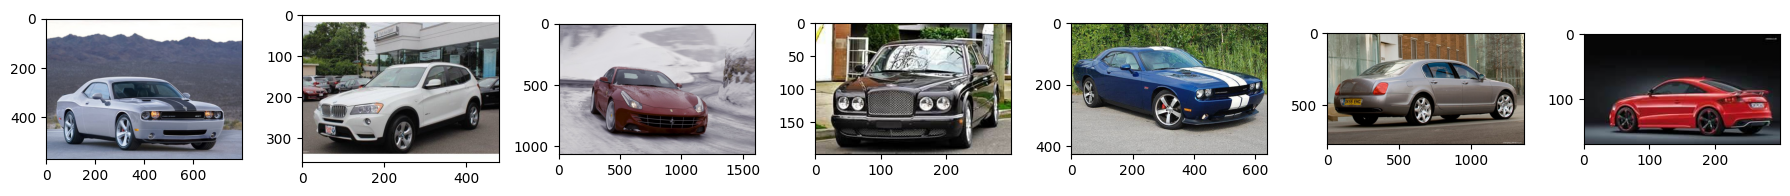

In [106]:
test_dataset.print_samples()

In [ ]:
predictions = test_dataset.predict(test_dataloader, resnet.model)

In [ ]:
test_dataset.write_predictions(predictions, "/sample.csv", "answer.csv")

In [ ]:
print(len(predictions))
print(predictions)

### Sources

https://pytorch.org/vision/stable/models.html

https://discuss.pytorch.org/t/what-does-it-mean-to-normalize-images-for-resnet/96160